# Turing.jlで分位数データからパラメータを推定する

## モチベーション
データの分布を調べるためにTuring.jlを使っているが、1次データが常に手に入るとは限らない。特に調査会社のレポートはRAWデータを有料化するためおおまかな分位数データしか発表しないことが多い。分位数のデータから分布を予測する方法を具体例を通じて示したい。

## パッケージインストールとデータ読み込み

In [91]:
using Distributions,StatsPlots,Statistics,Turing,DynamicPPL,DataFrames,CSV,NamedArrays

## 分位数から分布を調べるとは？

Toyモデルで今回の課題を具体的に理解してみよう。通常は1次データとして観測された（Observed）サンプルから分布を推計する。

In [92]:
ss = rand(Normal(2.3,1.3),200);

In [93]:
@model function demo(xs)
    m ~ Normal(0,3)
    s ~ InverseGamma(2,3)
    xs .~ Normal(m,s)
end
ctest = sample(demo(ss),NUTS(),3000)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 1.16 seconds
Compute duration  = 1.16 seconds
parameters        = m, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           m    2.3109    0.0894     0.0016    0.0017   3400.2103    0.9998    ⋯
           s    1.2457    0.0615     0.0011    0.0012   2836.6168    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

しかし入手できるデータが次のような分位数（quantile)データだけの場合もある。

In [4]:
qv = [0.25,0.5,0.75,0.95]
qs = quantile(ss,qv)
NamedArray(qs',(["Quantile"],qv))

1×4 Named LinearAlgebra.Adjoint{Float64, Vector{Float64}}
   A ╲ B │    0.25      0.5     0.75     0.95
─────────┼───────────────────────────────────
Quantile │ 1.44301  2.30823  3.05904  4.16651

分位数から分布のパラメーターを調べるモデルは次のようになる

In [5]:
@model function q_demo()
    m ~ Normal(0,3)
    s ~ InverseGamma(2,3)
    dist = Normal(m,s)
    q25 ~ Normal(quantile(dist,0.25),0.2)
    q50 ~ Normal(quantile(dist,0.5),0.2)
    
    q25 ~ Normal(qs[1],0.1)
    q50 ~ Normal(qs[2],0.1)
end
qtest = sample(q_demo(),NUTS(),3000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 6.69 seconds
Compute duration  = 6.69 seconds
parameters        = m, s, q25, q50
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           m    2.2868    0.2011     0.0037    0.0045   1989.7591    0.9999    ⋯
           s    1.2515    0.3785     0.0069    0.0085   1951.9221    0.9998    ⋯
         q25    1.4451    0.0986     0.0018    0.0021   2549.6215    1.0009    ⋯
         q50    2.3034    0.0973     0.0018    0.0021   2021.1564    1.0007    ⋯
                                                           

あるいはこういう書き方も可能。

In [6]:
@model function prob_demo()
    m ~ Normal(0,3)
    s ~ InverseGamma(2,3)
    dist = Normal(m,s)
    q25 = quantile(dist,0.25)
    q50 = quantile(dist,0.5)
    
    # This code is suggestied by torfjelde(Tor Erlend Fjelde)
    # see this page.
    # https://discourse.julialang.org/t/turing-jl-prior-on-quantiles/59510/2
    DynamicPPL.@addlogprob! logpdf(Normal(qs[1],0.1), q25 )
    DynamicPPL.@addlogprob! logpdf(Normal(qs[2],0.1), q50 )

end
qtest = sample(prob_demo(),NUTS(),3000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 2.04 seconds
Compute duration  = 2.04 seconds
parameters        = m, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           m    2.3001    0.0992     0.0018    0.0032   778.8730    1.0002     ⋯
           s    1.2578    0.2009     0.0037    0.0062   837.8246    1.0009     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

理想的な分布を探せるケースはほとんどない。現実はモデルにfitしないのである

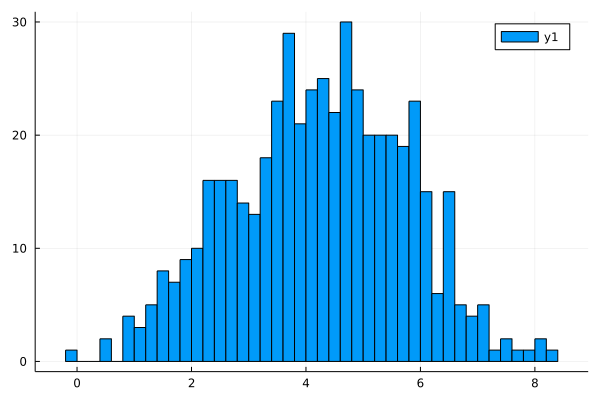

In [76]:
s1=rand(Normal(5,1.2),300)
s2=rand(Normal(3,1.2),200);
ss=vcat(s1,s2);
histogram(ss,bins=50)

In [77]:
c_demo = sample(demo(ss),NUTS(),3000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 0.26 seconds
Compute duration  = 0.26 seconds
parameters        = m, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           m    4.2324    0.0682     0.0012    0.0015   3024.8208    0.9997    ⋯
           s    1.5121    0.0485     0.0009    0.0009   3127.0171    1.0009    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

In [78]:
m = get(c_demo,[:m,:s]).m |> mean
s = get(c_demo,[:m,:s]).s |> mean

1.512143580221707

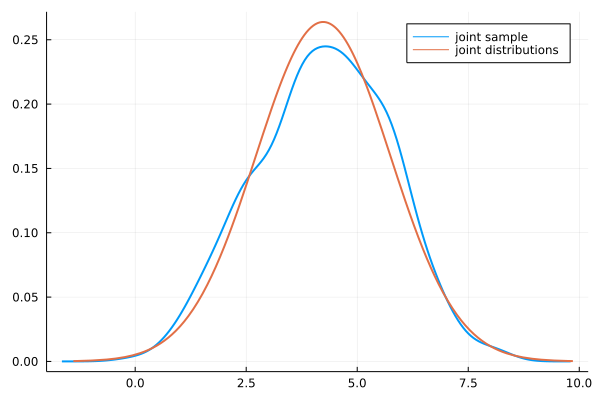

In [79]:
density(ss,lw=2,label="joint sample")
plot!(Normal(m,s),lw=2,label="joint distributions")

In [90]:
using LinearAlgebra
@model function two_demo(xs)
    n = length(xs)
    m ~ arraydist([Normal(2,2),Normal(4,2)])
    s ~ filldist(InverseGamma(2,3),2)
    
    w ~ Dirichlet(2,1)
    k = Vector{Any}(undef,n)
    for i = 1:n
         k[i] ~ Categorical(w)
        xs[i] ~ Normal( m[k[i]], s[k[i]]) 
    end
end

two_demo (generic function with 2 methods)

In [57]:
model2 =two_demo(ss)
c_two = sample(model2,Gibbs(PG(50,:k),HMC(0.05,10,:m,:s,:w)),3000)

Sampling: 100%|█████████████████████████████████████████| Time: 2:04:49


Chains MCMC chain (3000×507×1 Array{Float64, 3}):

Iterations        = 1:1:3000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 7529.77 seconds
Compute duration  = 7529.77 seconds
parameters        = m[1], m[2], s[1], s[2], w[1], w[2], k[1], k[2], k[3], k[4], k[5], k[6], k[7], k[8], k[9], k[10], k[11], k[12], k[13], k[14], k[15], k[16], k[17], k[18], k[19], k[20], k[21], k[22], k[23], k[24], k[25], k[26], k[27], k[28], k[29], k[30], k[31], k[32], k[33], k[34], k[35], k[36], k[37], k[38], k[39], k[40], k[41], k[42], k[43], k[44], k[45], k[46], k[47], k[48], k[49], k[50], k[51], k[52], k[53], k[54], k[55], k[56], k[57], k[58], k[59], k[60], k[61], k[62], k[63], k[64], k[65], k[66], k[67], k[68], k[69], k[70], k[71], k[72], k[73], k[74], k[75], k[76], k[77], k[78], k[79], k[80], k[81], k[82], k[83], k[84], k[85], k[86], k[87], k[88], k[89], k[90], k[91], k[92], k[93], k[94], k[95], k[96], k[97], k[98], k[99], k[100], k[101], k[102], k[103], k[104], k[105], k[106], k[107

In [82]:
mands=get(c_two,[:m,:s,:w])

(m = ([2.0986324267669505; 2.0986324267669505; … ; 2.0986324267669505; 2.0986324267669505;;], [4.267345153428818; 4.267345153428818; … ; 4.267345153428818; 4.267345153428818;;]), w = ([0.00065399924380792; 0.00065399924380792; … ; 0.00065399924380792; 0.00065399924380792;;], [0.9993460007561921; 0.9993460007561921; … ; 0.9993460007561921; 0.9993460007561921;;]), s = ([1.635715538813403; 1.635715538813403; … ; 1.635715538813403; 1.635715538813403;;], [0.41713500153339667; 0.41713500153339667; … ; 0.41713500153339667; 0.41713500153339667;;]))

In [87]:
m1 = mands.m[1]|>mean
m2 = mands.m[2]|>mean
s1 = mands.s[1]|>mean
s2 = mands.s[2]|>mean
w1 = mands.w[1]|>mean
w2 = mands.w[2]|>mean
(m1,s1,m2,s2,w1,w2)

(2.0986324267669505, 1.6357155388134021, 4.267345153428814, 0.4171350015333966, 0.0006539992438079206, 0.9993460007561913)

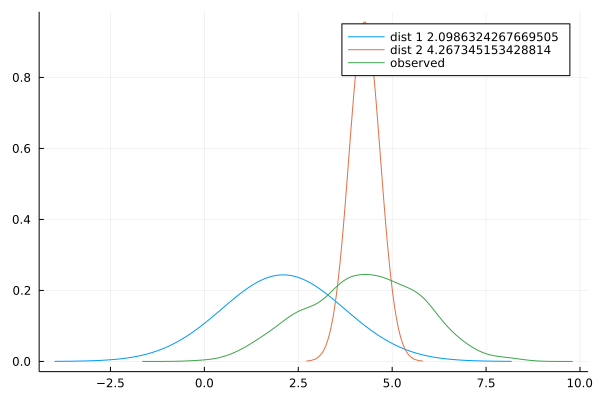

In [85]:
plot(Normal(m1,s1),label="dist 1 $(mean(m1))")
plot!(Normal(m2,s2),label="dist 2 $(mean(m2))")
density!(ss,label="observed")

In [89]:
n= length(ss)
w1n = round( n * w1) ; w2n = n - w1n
s1w = rand(Normal(m1,s1),w1n)
s2w = rand(Normal(m2,s2),w2n)
sw = vcat(s1w,s2w)
density(sw,lw=2,label="Joint Distributions")
density!(ss,lw=2,label="Observed")

LoadError: MethodError: no method matching rand(::Normal{Float64}, ::Float64)
[0mClosest candidates are:
[0m  rand([91m::AbstractVector{<:Random.AbstractRNG}[39m, ::Any, [91m::Int64[39m) at C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\utilities.jl:9
[0m  rand([91m::AdvancedMH.Proposal[39m, ::Any...) at C:\Users\kimse\.julia\packages\AdvancedMH\rD4EE\src\proposal.jl:24
[0m  rand(::Sampleable, [91m::Tuple{Vararg{Int64, N}} where N[39m) at C:\Users\kimse\.julia\packages\Distributions\1PkiH\src\genericrand.jl:23
[0m  ...

モデルが正しく推定できたことを確認できたので、実際の問題を解決してみよう。

## マラソン大会の人員手配を考える
[北海道マラソン](https://hokkaido-marathon.com/)がもうすぐ開催されるので、これを事例にしてみる。出展ブースで完走者全員に記念品を手渡したい。ランナーたちはスタートから2時間～6時間で到着する。スタッフを雇う時間は限られているので、ランナーがもっとも多くゴールする時間帯にあわせてスタッフの人数と配置を考えたい。もっとも多くのランナーが到着するのはスタートから何分ごろと考えるべきだろうか？

北海道マラソン運営は[完走タイム別人数分布表](https://hokkaido-marathon.com/data/distribution/)を公開している。残念ながらRAWデータではなく、スタートから2時間から4時間までの10分刻みの完走人数と4～5時間のランナーはひとつの区分で表示している。発表データを以下の表に転記する。最終ランナーの締め切りは300分（5時間）として設定した。（2019年大会は制限時間5時間でしたが、2022年大会は制限時間が6時間になったようです）

|タイム（分）|男子|女子|合計
|--------|-----|-----|-----|
|～140|29  |  0|   29|
|141～150|	25|	0|	25|
|151～160|	83|	5|	88|
|161～170| 127 |	7|134
|171～180| 281 |	11|292
|181～190| 268 |	26 |294
|191～200| 470 | 36 |506
|201～210|	648|	60	|708
|211～220|	697|	86	|783
|221～230|	818|	117	|935
|231～240|	1112|	180|	1292
|241～300|6779|	1592|8371

## データ読み込み

興味の対象はランナー合計なので性別のデータは削除する。北海道マラソン2019の参加者は公式で15,932人と発表されている。制限時間にゴールした人は13,457人なので2475人が制限時間の5時間に間に合っていない。この点を考慮し分布データから分位数を算出する。

In [130]:
df = CSV.read("hokkaido-marason.csv",DataFrame)
df = df[:,Not([:male,:female])]
push!(df,[420,2475])
df.run_accum = accumulate(+,df[:,:runner])
df.run_accum_quantile = df.run_accum ./ 15932 ;df

,goal_time,runner,run_accum,run_accum_quantile
,Int64,Int64,Int64,Float64
1,140,29,29,0.00182024
2,150,25,54,0.0033894
3,160,88,142,0.00891288
4,170,134,276,0.0173236
5,180,292,568,0.0356515
6,190,294,862,0.0541049
7,200,506,1368,0.0858649
8,210,708,2076,0.130304
9,220,783,2859,0.17945


StasPlotsのEqual-area histogramsでゴールタイムの分布を確認する。300分以上のランナーが2475人いることも忘れずに241分～360分までのデータが喪失しているがNormal Distributionsでよさそうだ。

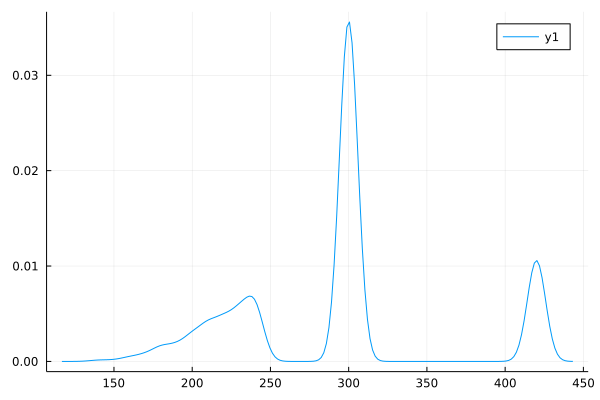

In [132]:
v = [fill(df[i,:goal_time],df[i,:runner]) for i =1:13 ] |> t -> vcat(t...)
density(v)

In [133]:
savefig("record.png")

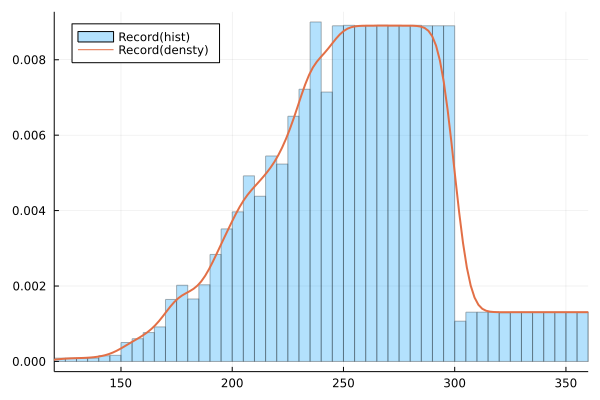

In [175]:
#mean_time = [140,145,155,165,175,185,195,205,215,225,235,300]
mean_f = [120,141,151,161,171,181,191,201,211,221,231,241,301]
mean_t = [140,150,160,170,180,190,200,210,220,230,240,300,420]
mean_record = [collect(range(mean_f[i],mean_t[i] ; length=df[i,:runner])) for i = 1:13]  |> t -> vcat(t...)
histogram(mean_record,normalize=:pdf,label="Record(hist)",xlims=(120,360),alpha=0.3)
density!(mean_record,label="Record(densty)",lw=2,legend=:topleft)

In [176]:
savefig("hokkaido-M_record.png")

## 分位数データから分布パラメータを推定する

In [138]:
@model function findfromquantile(tim,acc)
    n = length(tim)
    μ ~ InverseGamma(2,3)
    σ ~ InverseGamma(2,3)
    s ~ Truncated(Normal(0,3),0,10)

    dist = Normal(μ,σ)
    q = Vector{Any}(undef,length(acc))
    for i = 1:n
        q[i] ~ Normal(quantile(dist,acc[i]),s)
        q[i] ~ Normal(tim[i],s)    
    end
end

findfromquantile (generic function with 2 methods)

分位数100％はパラメタ推定にとって無意味(Infを探してしまう）なので除いてモデルに渡す。

In [139]:
model = findfromquantile(df[1:(end-1),:goal_time],df[1:(end-1),:run_accum_quantile])
c_quantile = sample(model,NUTS(),3000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHM

Chains MCMC chain (3000×27×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 3.86 seconds
Compute duration  = 3.86 seconds
parameters        = μ, σ, s, q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   257.5399    1.1390     0.0208    0.0262   1868.9463    1.0022   ⋯
           σ    41.0041    0.6355     0.0116    0.0138   1800.3685    1.0016   ⋯
           s     1.6365    0.4135     0.0075    0.0120    935.8573    1.0001   ⋯
        q[1]   139.1900    1.3146     0.0240    0.0231   2678.7257    0.

In [140]:
summary_report, quantile_report = describe(c_quantile[:,[:μ,:σ],:])
summary_report

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   257.5399    1.1390     0.0208    0.0262   1868.9463    1.0022   ⋯
           σ    41.0041    0.6355     0.0116    0.0138   1800.3685    1.0016   ⋯
                                                                1 column omitted


In [141]:
quantile_report

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           μ   255.2174   256.8034   257.5737   258.2784   259.7486
           σ    39.7112    40.6044    41.0198    41.4147    42.2425


In [ ]:
c_quantile

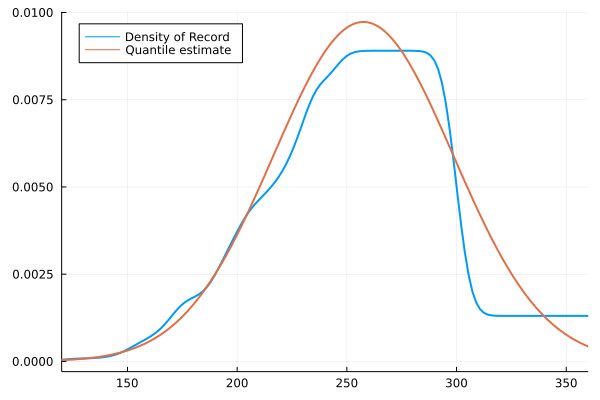

In [162]:
m_1 = get(c_quantile,[:μ]).μ |> mean
o_1 = get(c_quantile,[:σ]).σ |> mean
quantile_est_dist = Normal(m_1,o_1)
#histogram(mean_record,normalize=:pdf,label="Record(Mean assumed)",xlims=(120,360),alpha=0.3)
density(mean_record,lw=2,label="Density of Record",legend=:topleft,xlims=(120,360))
plot!(quantile_est_dist,lw=2,label="Quantile estimate")

In [144]:
savefig("quantile-estimate.png")

推定した分布をもとにサンプリングして実際の記録値と比較してみる

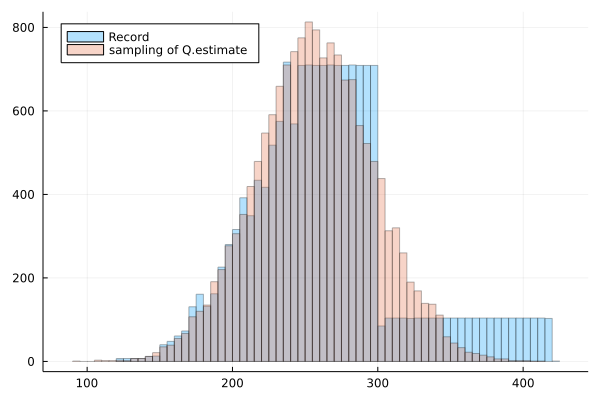

In [163]:
histogram(mean_record,label="Record",legend=:topleft,alpha=0.3)
histogram!(rand(quantile_est_dist,length(mean_record)),label="sampling of Q.estimate",alpha=0.3)

In [146]:
df.run_quantile_cdf=cdf(quantile_est_dist,df[:,:goal_time]);df

,goal_time,runner,run_accum,run_accum_quantile,run_quantile_cdf
,Int64,Int64,Int64,Float64,Float64
1,140,29,29,0.00182024,0.0020749
2,150,25,54,0.0033894,0.00436225
3,160,88,142,0.00891288,0.00868485
4,170,134,276,0.0173236,0.0163842
5,180,292,568,0.0356515,0.0293101
6,190,294,862,0.0541049,0.0497634
7,200,506,1368,0.0858649,0.0802676
8,210,708,2076,0.130304,0.123147
9,220,783,2859,0.17945,0.17996


### やや外れた感がある。標準分布を想定したことは間違いだろうか？

おそらく分布としては標準分布よりGamma分布のほうがモデルとして適しているかもしれない。なぜならGamma分布はそれぞれ独立した事象の到着時間を表す分布だから、マラソンのゴール時間を表現するには適していると思われるからだ。しかし実はJuliaのgamma関数が自動微分をサポートしないためTuringでGamma分布やGamma関数を扱うには制限がある。実際前項で示した分位数から推定する方法がGamma分布ではエラーになってしまう。したがってGamma分布を調べるためにはサンプリングから分布を調べる方法しか思いつかない。

## サンプリングデータからGamma分布を調べる
分位数データに沿ってサンプルを作成し、MCMCでパラメータを調べる。この方法の最大の欠点は、データレコードの一部があいまいなため（〇〇時間以上など）、ご都合な仮定（同幅の時間に選手が返ってくる）を採用せざるを得ずデータ喪失が行われるので注意しなければならない。

In [147]:
@model function gamma_sample_find(xs)
    a ~ InverseGamma(2,3)
    b ~ InverseGamma(2,3)
    xs .~ Gamma(a,b)    
end

gamma_sample_find (generic function with 2 methods)

In [150]:
model = gamma_sample_find(mean_record)
c1 = sample(model,NUTS(),3000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:56


Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 56.33 seconds
Compute duration  = 56.33 seconds
parameters        = a, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           a   25.8691    0.2899     0.0053    0.0128   487.9097    1.0007     ⋯
           b   10.2743    0.1168     0.0021    0.0052   491.9387    1.0007     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        

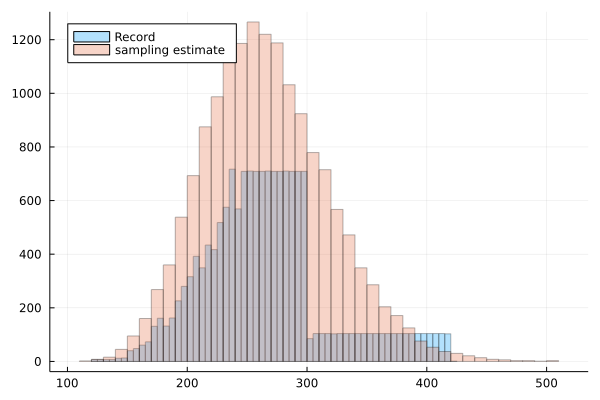

In [151]:
a_1 = get(c1,[:a]).a |> mean
b_1 = get(c1,[:b]).b |> mean
histogram(mean_record,label="Record",legend=:topleft,alpha=0.3)
sample_dist = Gamma(a_1,b_1)
histogram!(rand(sample_dist,length(mean_record)),label="sampling estimate",alpha=0.3)

In [111]:
savefig("sample-estimate.png")

サンプリングデータから推定した分布パラメータが実際の測定値とどれくらい乖離があるかを比較する。231分～240分では9％の差がありうまく表現できてるといえない結果となった。

In [152]:
df.run_sampling_cdf=cdf(sample_dist,df[:,:goal_time]);df

,goal_time,runner,run_accum,run_accum_quantile,run_quantile_cdf,run_sampling_cdf
,Int64,Int64,Int64,Float64,Float64,Float64
1,140,29,29,0.00182024,0.0020749,0.00200278
2,150,25,54,0.0033894,0.00436225,0.00482175
3,160,88,142,0.00891288,0.00868485,0.0103839
4,170,134,276,0.0173236,0.0163842,0.0202917
5,180,292,568,0.0356515,0.0293101,0.0364148
6,190,294,862,0.0541049,0.0497634,0.0606226
7,200,506,1368,0.0858649,0.0802676,0.094439
8,210,708,2076,0.130304,0.123147,0.138705
9,220,783,2859,0.17945,0.17996,0.193337


In [153]:
using ForwardDiff,StatsFuns,SpecialFunctions

In [172]:
function SpecialFunctions.__gamma_inc_inv(a::ForwardDiff.Dual{T}, minpq::ForwardDiff.Dual{T}, pcase::Bool) where {T}
    
    v_a= ForwardDiff.value(a)
    v_pq = ForwardDiff.value(minpq)
    p_a = ForwardDiff.partials(a).values
    p_pq = ForwardDiff.partials(minpq).values

    SpecialFunctions.__gamma_inc_inv(v_a,v_pq,pcase)
end

In [173]:
@model function gamma_quantile_find(tim,acc)
    n = length(tim)
     k ~ InverseGamma(2,3)
    θ ~ InverseGamma(2,3)
     s ~ Truncated(Normal(0,3),0,10)
   
    dist = Gamma(k,θ)
    
    q = Vector{Any}(undef,length(acc))
    for i = 1:n
        q[i] ~ Normal(quantile(dist,acc[i]),s)
        q[i] ~ Normal(tim[i],s)    
    end
end   

gamma_quantile_find (generic function with 2 methods)

In [174]:
model = gamma_quantile_find(df[1:(end-1),:goal_time],df[1:(end-1),:run_accum_quantile])
g_quantile = sample(model,NUTS(),3000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\kimse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\

Chains MCMC chain (3000×27×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 160.41 seconds
Compute duration  = 160.41 seconds
parameters        = k, θ, s, q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           k    31.0615    1.5395     0.0281    0.1923     9.1832    1.4837    ⋯
           θ     8.3589    0.4684     0.0086    0.0588     8.9337    1.5045    ⋯
           s     2.7442    0.6747     0.0123    0.0811    17.3526    1.0205    ⋯
        q[1]   141.9206    2.0349     0.0372    0.2417    28.6009   

In [185]:
params = get(g_quantile,[:k,:θ])
k = params.k |> mean
θ = params.θ |> mean

8.358930436726665

In [206]:
k_conf = get(g_quantile,[:k]).k |> vec |>  t->quantile(t,[0.025,0.975])
th_conf = get(g_quantile,[:θ]).θ |> vec |>  t->quantile(t,[0.025,0.975])
conf_min, conf_max = (mean(Gamma(k_conf[1],th_conf[1])),mean(Gamma(k_conf[2],th_conf[2])))

(211.31976487859777, 316.9718942578355)

In [216]:
mus = get(c_quantile,[:μ,:σ]).μ |> vec |> t->quantile(t,[0.025,0.975])
sigs = get(c_quantile,[:μ,:σ]).σ |> vec |> t->quantile(t,[0.025,0.975])
nor_max = maximum(mus) + 2*maximum(sigs)
nor_min = minimum(mus) - 2*maximum(sigs)

170.73247279086024

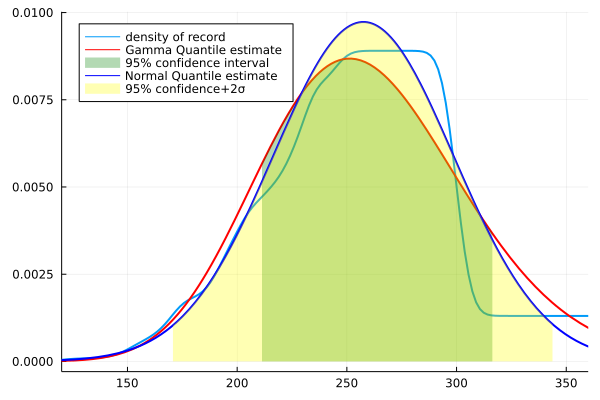

In [223]:
density(mean_record,lw=2,label="density of record",legend=:topleft,xlims=(120,360))
plot!(Gamma(k,θ),lw=2,label="Gamma Quantile estimate",color=:red)
plot!(Gamma(k,θ),conf_min:conf_max,fill=(0,0.3,:green),lw=0,label="95% confidence interval")
plot!(quantile_est_dist,lw=2,label="Normal Quantile estimate",color=:blue)
plot!(quantile_est_dist,nor_min:nor_max,fill=(0,0.3,:yellow),lw=0,label="95% confidence+2σ")
#vline!([mean(quantile_est_dist),mean(Gamma(k,θ))],ls=:dash,label="mean of dist")

In [224]:
savefig("marathon-3graph.png")

In [180]:
df.run_gamma_quantile=cdf(Gamma(k,θ),df[:,:goal_time]);df[:,4:end]

,run_accum_quantile,run_quantile_cdf,run_sampling_cdf,run_gamma_quantile
,Float64,Float64,Float64,Float64
1,0.00182024,0.0020749,0.00200278,0.00107976
2,0.0033894,0.00436225,0.00482175,0.00301543
3,0.00891288,0.00868485,0.0103839,0.00735496
4,0.0173236,0.0163842,0.0202917,0.0159439
5,0.0356515,0.0293101,0.0364148,0.0311691
6,0.0541049,0.0497634,0.0606226,0.0556341
7,0.0858649,0.0802676,0.094439,0.0916341
8,0.130304,0.123147,0.138705,0.140568
9,0.17945,0.17996,0.193337,0.20247


In [181]:
mean(Gamma(k,θ))

259.1417456392973

parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           k    29.8842    30.8678    31.3752    31.9094    33.0545
           θ     7.8122     8.0934     8.2521     8.4085     8.7225

In [182]:
mean(Gamma(29.8842,7.8122))

233.46134723999998

In [183]:
mean(Gamma(33.0545,8.7225))

288.31787625